In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("resumes/processed_resumes_work.csv",header=None)
data.columns = ['city','resume_id','container','role','company','location','dates','descript']

In [3]:
data.groupby("city").resume_id.count()

city
atlanta    156375
austin      91072
boston     136890
dc         165465
denver     143653
miami      139766
minn       139604
nyc        163303
seattle     86233
sf          96307
Name: resume_id, dtype: int64

In [4]:
# There are only 7139 job descriptions without a date. Let's drop those.
print("Missing dates:", data[data.dates.isnull()].resume_id.count())

# There are only 76,792 job without a description and 1,241,876 with a description. 
# Let's try to keep those in for now
print("Missing description:", data[~data.descript.isnull()].resume_id.count())

Missing dates: 7139
Missing description: 1241876


In [5]:
# Removed jobs without dates
data = data[~data.dates.isnull()]

In [6]:
# There is one record with an end date after present day.
# Let's update the end date to present day
data.dates.loc[data.dates == 'January 2000 to January 2020'] = 'January 2000 to June 2018'

In [19]:
# Split date information
# If no end date, then use the start date as the end date
# If "Present" for end date, then use June 2018 as the end date
data['from_date'] = data.dates.apply(lambda x: (x.split(" to ")[0]).strip())
data['from_date'] = data.from_date.apply(lambda x: 
                        datetime.datetime.strptime('January ' + x, '%B %Y')
                        if len(x.split(" "))==1
                        else datetime.datetime.strptime(x, '%B %Y'))
data['to_date'] = data.dates.apply(lambda x: (x.split(" to ")[1]).strip()
                        if len(x.split(" to "))>1
                        else x.strip())
data.to_date.loc[data.to_date == 'Present'] = 'June 2018'
data['to_date'] = data.to_date.apply(lambda x: 
                        datetime.datetime.strptime('December ' + x, '%B %Y')
                        if len(x.split(" "))==1
                        else datetime.datetime.strptime(x, '%B %Y'))
data['to_year'] = data.to_date.apply(lambda x: str(x.year))
data['from_year'] = data.from_date.apply(lambda x: str(x.year))
data['days_worked'] = (data.to_date - data.from_date).dt.days
data['years_worked'] = round(data.days_worked/365)

/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
# There appear to be jobs with a start date after current date (June 10, 2018)
# Let's remove them from the dataset
print("Records with start date after current date:",
      data[data.from_date > '2018-06-10'].resume_id.count())
data = data[data.from_date <= '2018-06-10']

Records with start date after current date: 167


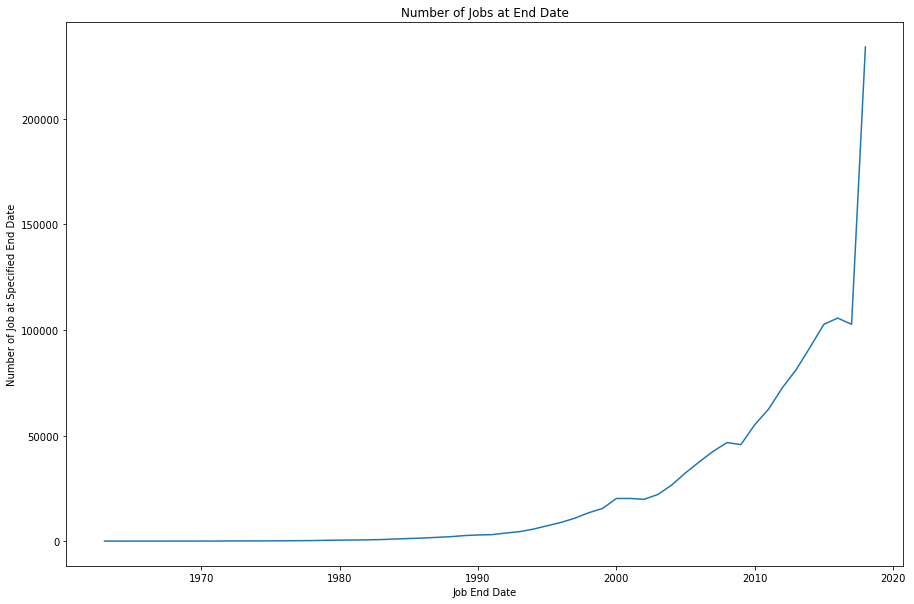

In [44]:
temp_data = pd.DataFrame(data\
.groupby(['to_year'])['resume_id'].count().reset_index())
plt.figure(figsize=(15,10))
plt.plot(temp_data.to_year, temp_data.resume_id)
plt.title('Count of Comments By Date')
plt.xlabel('Job End Date')
plt.ylabel('Number of Job at Specified End Date')
plt.title('Number of Jobs at End Date')
plt.show()

In [45]:
temp_data.sort_values(by='to_year', ascending=False).head()

,to_year,resume_id
55,2018,234042
54,2017,102672
53,2016,105613
52,2015,102664
51,2014,91795


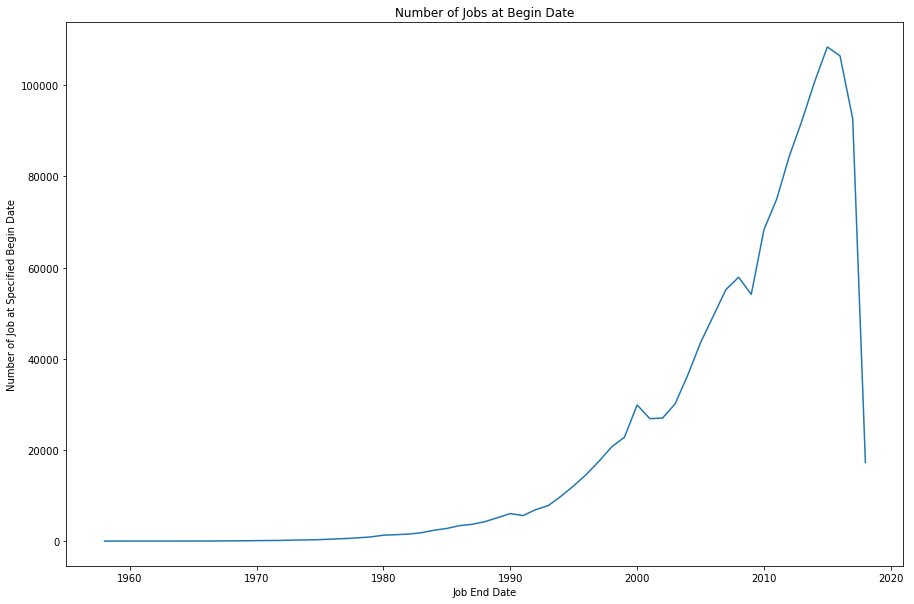

In [74]:
temp_data = pd.DataFrame(data.groupby(['from_year'])['resume_id'].count().reset_index())
plt.figure(figsize=(15,10))
plt.plot(temp_data.from_year, temp_data.resume_id)
plt.title('Count of Comments By Date')
plt.xlabel('Job End Date')
plt.ylabel('Number of Job at Specified Begin Date')
plt.title('Number of Jobs at Begin Date')
plt.show()

In [75]:
temp_data.sort_values(by='from_year', ascending=False).head()

,from_year,resume_id
58,2018,17236
57,2017,92612
56,2016,106419
55,2015,108391
54,2014,100795


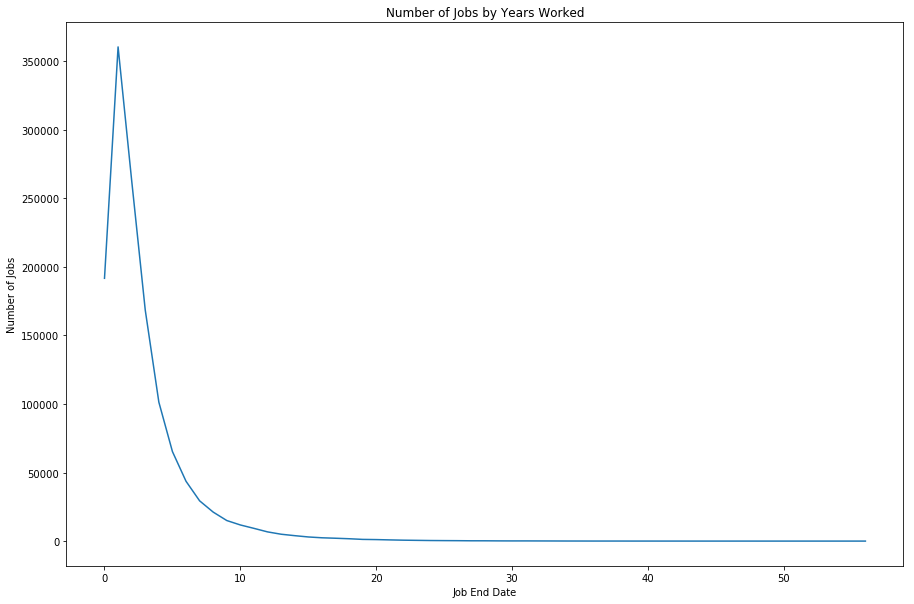

In [76]:
temp_data = pd.DataFrame(data.groupby(['years_worked'])['resume_id'].count().reset_index())
plt.figure(figsize=(15,10))
plt.plot(temp_data.years_worked, temp_data.resume_id)
plt.title('Years Worked')
plt.xlabel('Job End Date')
plt.ylabel('Number of Jobs')
plt.title('Number of Jobs by Years Worked')
plt.show()

In [79]:
temp_data.sort_values(by='resume_id', ascending=False).head()

,years_worked,resume_id
1,1.0,360239
2,2.0,262843
0,0.0,191562
3,3.0,168359
4,4.0,101300


In [32]:
# Does education generally have dates?